In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
import matplotlib.patches as mpatches
import geopandas as gpd
from rasterio.mask import mask
import shapely.geometry
from itertools import combinations
import warnings
from rasterio.plot import show
from affine import Affine


warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from datetime import datetime
import matplotlib.transforms as mtransforms

plt.rcParams.update({"font.size": 14})


In [2]:
bbox_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [-95.514107383931105, 28.837294991608498],
            [-95.542191067157702, 28.82310160914],
            [-95.533023536824004, 28.807894014576299],
            [-95.5039012207138, 28.822751403692301],
            [-95.514107383931105, 28.837294991608498],
        ]
    ],
}


In [3]:
NAVD88toMSL = -0.09

def clip_raster(filepath, bbox_geojson):
    bbox_geom = gpd.GeoDataFrame.from_features(
        [{"type": "Feature", "properties": {}, "geometry": bbox_geojson}],
        crs="EPSG:4326",
    )
    with rasterio.open(filepath) as src:
        src_crs = src.crs if src.crs else "EPSG:4326"
        bbox_geom = bbox_geom.to_crs(crs=src_crs)
        intersection = bbox_geom.unary_union.intersection(
            shapely.geometry.box(*src.bounds)
        )
        if not intersection.is_empty:
            out_image, out_transform = mask(src, shapes=[intersection], crop=True)
            
            out_image = out_image + NAVD88toMSL
            out_image[out_image < -1000] = np.nan
            out_meta = src.meta.copy()
            out_meta.update(
                {
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "nodata": np.nan,
                }
            )
            

            return out_image.squeeze(), out_transform, out_meta
    return None, None, None


In [4]:
def rotate_image(
    image, transform, meta, angle, shift_x=0, shift_y=0, adj_width=0, adj_height=0
):

    src_transform = transform
    rotate = Affine.rotation(angle)
    trans_x = Affine.translation(shift_x, 0)
    trans_y = Affine.translation(0, -shift_y)
    dst_transform = src_transform * rotate * trans_x * trans_y

    y, x = image.shape
    dst_height = int(y + adj_height)
    dst_width = int(x + adj_width)

    dst_image = np.empty(
        shape=(image.shape[0], dst_height, dst_width), dtype=image.dtype
    )

    meta.update(
        {
            "transform": dst_transform,
            "height": dst_height,
            "width": dst_width,
            "nodata": np.nan,
        }
    )

    reproject(
        source=image,
        destination=dst_image,
        src_transform=src_transform,
        dst_transform=dst_transform,
        src_crs=meta["crs"],
        dst_crs=meta["crs"],
        resampling=Resampling.nearest,
        src_nodata=meta.get("nodata"),
        dst_nodata=np.nan,
    )

    # Find the bounding box where data exists
    valid_data_positions = np.where(~np.isnan(dst_image))
    ymin, xmin = valid_data_positions[1].min(), valid_data_positions[2].min()
    ymax, xmax = valid_data_positions[1].max(), valid_data_positions[2].max()

    # Clip the image to the bounding box
    dst_image_clipped = dst_image[:, ymin : ymax + 1, xmin : xmax + 1]
    plt.imshow(dst_image_clipped[0], cmap="gray")
    plt.title("Rotated and Clipped Image")
    plt.show()

    # Update metadata for the clipped image
    new_height, new_width = dst_image_clipped.shape[1], dst_image_clipped.shape[2]
    new_transform = dst_transform * Affine.translation(xmin, ymin)
    meta.update(
        {
            "transform": new_transform,
            "height": new_height,
            "width": new_width,
        }
    )

    return dst_image_clipped, new_transform, meta


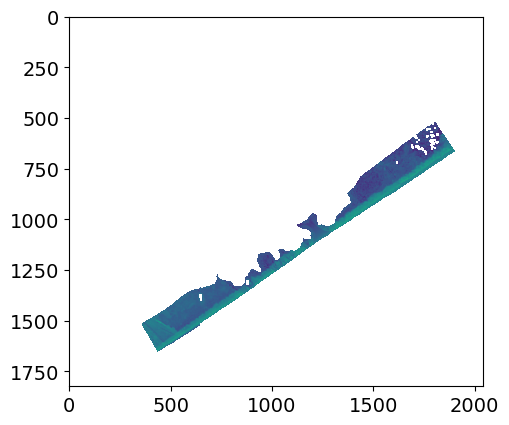

<Axes: >

In [5]:
filepath = "Clipped(2001)_meter.tif"
out_image, out_transform, out_meta = clip_raster(filepath, bbox_geojson)
show(out_image)

In [67]:
angle = 34
shift_x = -1000
shift_y = 0
adj_width = 2000
adj_height = 500

out_image, out_transform, out_meta = rotate_image(
    out_image, out_transform, out_meta, angle, shift_x=0, shift_y=0, adj_width=0, adj_height=0
)


In [12]:
transform = out_transform
image = out_image
meta = out_meta
angle = 34
angle = 34
shift_x = -1000
shift_y = 0
adj_width = 2000
adj_height = 500

In [13]:
src_transform = transform
rotate = Affine.rotation(angle)
trans_x = Affine.translation(shift_x, 0)
trans_y = Affine.translation(0, -shift_y)
dst_transform = src_transform * rotate * trans_x * trans_y

y, x = image.shape
dst_height = int(y + adj_height)
dst_width = int(x + adj_width)

dst_image = np.empty(
    shape=(image.shape[0], dst_height, dst_width), dtype=image.dtype
)

meta.update(
    {
        "transform": dst_transform,
        "height": dst_height,
        "width": dst_width,
        "nodata": np.nan,
    }
)

In [6]:
out_transform

Affine(1.8300754567669086, 0.0, 1167769.7071833706,
       0.0, -1.8300754567669086, 2918232.799149935)